In [1]:
# !pip install tensorflow
# !pip install keras
# !pip uninstall numpy --yes
# !pip install numpy --no-cache-dir

## Time to try a convnet!

In [2]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
import os
import random
import time
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
from matplotlib import patheffects as path_effects
from IPython.display import Image as Image_
from IPython.display import display
import six
from six.moves import zip  # pylint: disable=redefined-builtin
from six.moves import xrange  # pylint: disable=redefined-builtin
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pylab as pl

%matplotlib inline

/home/developer/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Instantiate

In [3]:
## start construction of sequential model (layers follow each other)
classifier = Sequential()

## set up 
classifier.add(Conv2D(32, (3, 3), input_shape = (64, 64, 3)))
classifier.add(Activation('relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))
classifier.add(Flatten())
classifier.add(Dense(units = 64))
classifier.add(Activation('relu'))
classifier.add(Dropout(0.3))
classifier.add(Dense(1))
classifier.add(Activation('sigmoid'))

classifier.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['accuracy'])

### Preprocess

In [4]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow_from_directory(
    'assets/training_set',
    target_size = (64, 64),
    batch_size = 32,
    seed = 421,
    classes = ['micro', 'chest'],
    class_mode = 'binary')

test_generator = test_datagen.flow_from_directory(
    'assets/testing_set',
    target_size = (64, 64),
    batch_size = 32,
    seed = 421,
    classes = ['micro', 'chest'],
    class_mode = 'binary')

Found 7912 images belonging to 2 classes.
Found 1978 images belonging to 2 classes.


### Build

In [5]:
batch_size = 15

classifier.fit_generator(
    train_generator,
    steps_per_epoch = 8000 // batch_size,
    epochs = 25,
    validation_data = test_generator,
    validation_steps = 2000 // batch_size)

Epoch 1/25
533/533 [==============================] - 104s 194ms/step - loss: 0.0997 - acc: 0.9737 - val_loss: 0.0311 - val_acc: 0.9918
Epoch 2/25
533/533 [==============================] - 102s 192ms/step - loss: 0.0470 - acc: 0.9900 - val_loss: 0.0226 - val_acc: 0.9932
Epoch 3/25
533/533 [==============================] - 101s 190ms/step - loss: 0.0431 - acc: 0.9922 - val_loss: 0.0170 - val_acc: 0.9955
Epoch 4/25
533/533 [==============================] - 100s 187ms/step - loss: 0.0351 - acc: 0.9921 - val_loss: 0.0119 - val_acc: 0.9951
Epoch 5/25
533/533 [==============================] - 101s 190ms/step - loss: 0.0275 - acc: 0.9934 - val_loss: 0.0665 - val_acc: 0.9840
Epoch 6/25
533/533 [==============================] - 106s 198ms/step - loss: 0.0339 - acc: 0.9933 - val_loss: 0.0244 - val_acc: 0.9939
Epoch 7/25
533/533 [==============================] - 101s 190ms/step - loss: 0.0294 - acc: 0.9934 - val_loss: 0.0348 - val_acc: 0.9915
Epoch 8/25
533/533 [============================

### Validate

In [6]:
validation_df = pd.DataFrame(columns = ['y_test', 'y_pred'])
valid_path = []
for which in ['micro', 'chest']:
    y_pred = []
    y_actual = []
    folder = 'other_assets/validation_set/{}'.format(which)
    for file in os.listdir(folder):
        filepath = os.path.join(folder, file)
        test_image = image.load_img(filepath, target_size = (64, 64))
        test_image = image.img_to_array(test_image)
        test_image = np.expand_dims(test_image, axis = 0)
        result = classifier.predict(test_image)
        if which == 'micro':
            if result[0][0] == 1:
                y_pred.append(1)     ## false positive
                y_actual.append(0)
            else:
                y_pred.append(0)     ## true negative
                y_actual.append(0)
        elif which == 'chest':
            if result[0][0] == 1:
                y_pred.append(1)     ## true positive
                y_actual.append(1)
            else:
                y_pred.append(0)     ## false negative
                y_actual.append(1)
        valid_path.append(filepath)
    ys = pd.DataFrame(list(zip(y_actual, y_pred)), columns = ['y_test', 'y_pred'])
    validation_df = pd.concat([validation_df, ys], axis = 0).reset_index(drop = True)

validation_df = validation_df.applymap(lambda x: int(x))
validation_df = pd.concat([pd.DataFrame(valid_path, index = range(len(valid_path))), 
                           validation_df], axis = 1)
validation_df.columns = ['path', 'y_test', 'y_pred']
validation_df.head()

,path,y_test,y_pred
0,other_assets/validation_set/micro/micro_217.png,0,0
1,other_assets/validation_set/micro/micro_475.png,0,0
2,other_assets/validation_set/micro/micro_278.png,0,0
3,other_assets/validation_set/micro/micro_500.png,0,0
4,other_assets/validation_set/micro/micro_184.png,0,0


&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Check out some wrong predictions:

In [7]:
mask = [True if validation_df.loc[i, 'y_test'] != validation_df.loc[i, 'y_pred'] 
        else False for i in range(len(validation_df))]

wrong = validation_df[mask].reset_index(drop = True)

wrong[['y_test', 'y_pred']].sum()

y_test    43
y_pred     1
dtype: int64

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;So there was one time when the convnet predicted chest X-ray when the image was actually a microscope photo; there were 43 times when it predicted microscope photo instead of chest X-ray.  Let's check out the one and then five random samples from the others:

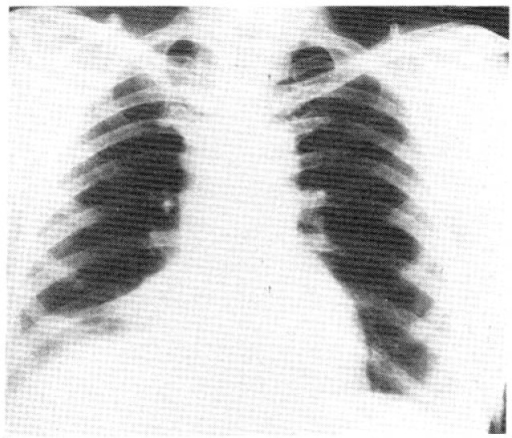

In [12]:
display(Image_(wrong.loc[wrong['y_pred'] == 1, 'path'][0]))

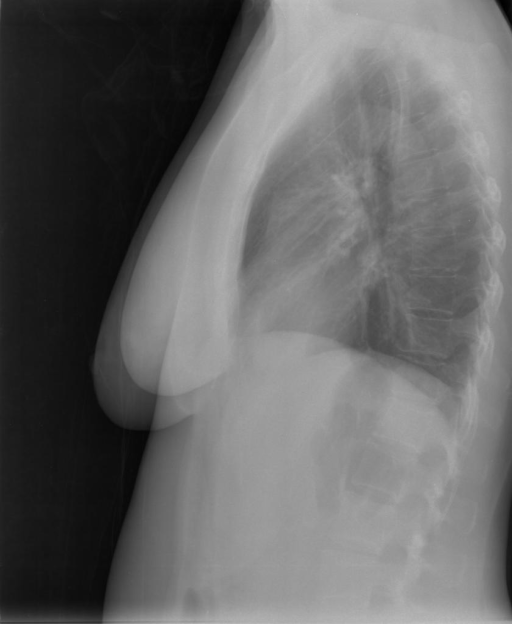

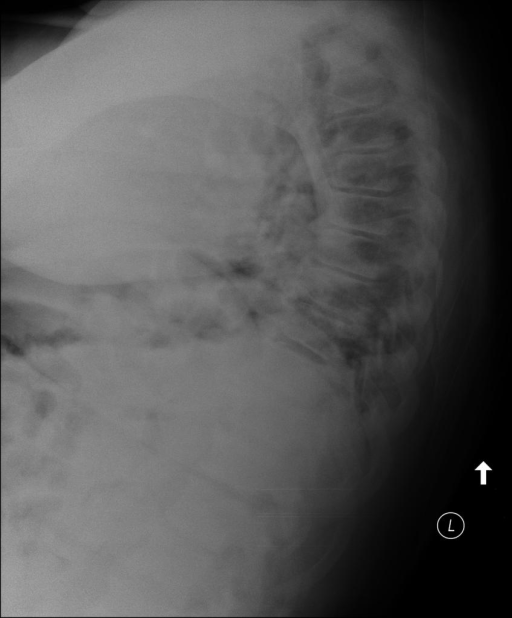

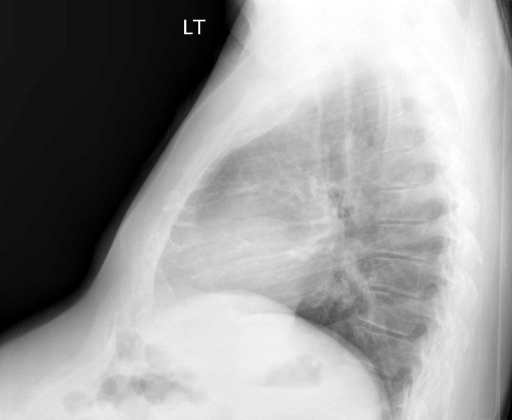

In [13]:
for i in range(3):
    rand = random.randint(0, len(wrong))
    path = wrong.loc[rand, 'path']
    time.sleep(1)
    display(Image_(path))

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Let's have a look at what the convnet is doing in the layers:

In [14]:
def nice_imshow(ax, data, vmin=None, vmax=None, cmap=None):
    """Wrapper around pl.imshow"""
    if cmap is None:
        cmap = cm.jet
    if vmin is None:
        vmin = data.min()
    if vmax is None:
        vmax = data.max()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    im = ax.imshow(data, vmin=vmin, vmax=vmax, interpolation='nearest', cmap=cmap)
    plt.colorbar(im, cax=cax)
    return

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;(Thanks to [this](https://github.com/julienr/ipynb_playground/blob/master/keras/convmnist/keras_cnn_mnist.ipynb) helpful repo for the viz code in this section.)

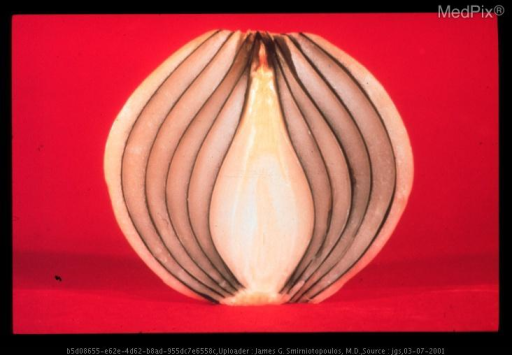

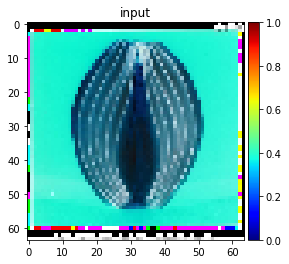

In [15]:
i = random.randint(1, 550)
true_class = 'micro'

path = 'assets/testing_set/{}/{}_{}.png'.format(true_class, true_class, i)
display(Image_(path))
test_image = image.load_img(path, target_size = (64, 64))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)

pl.figure()
pl.title('input')
nice_imshow(pl.gca(), np.squeeze(test_image), vmin=0, vmax=1, cmap = 'jet')

### Classification report & confusion matrix

In [18]:
y_test = validation_df['y_test']
y_pred = validation_df['y_pred']

confmat = confusion_matrix(y_test, y_pred)
confmat

array([[549,   1],
       [ 43, 507]])

In [19]:
def plot_confusion_matrix(
    confmat, 
    title = 'Confusion Matrix', 
    labels = ['Positive', 'Negative'], 
    cmap = plt.cm.Blues):

    plt.figure(figsize = (10, 6))
    plt.imshow(confmat, interpolation = 'nearest', cmap = cmap)

    plt.grid(b = False)

    width, height = confmat.shape
    
    tick_marks = np.arange(width)
    plt.xticks(tick_marks, labels, fontsize = 14)
    plt.yticks(tick_marks - 0.2, labels, rotation = 90, fontsize = 14)

    plt.title(title, fontsize = 18, y = 1.03)
    plt.ylabel('True label', fontsize = 18)
    plt.xlabel('Predicted label', fontsize = 18)
    plt.tight_layout()

    for x in xrange(width):
        for y in xrange(height):
            plt.annotate(
                str(confmat[x][y]), 
                xy = (y, x), 
                horizontalalignment = 'center', 
                verticalalignment = 'center', 
                color = 'white', 
                fontsize = 40).set_path_effects([path_effects.Stroke(linewidth = 1, 
                                                                     foreground = 'black'), 
                                                 path_effects.Normal()])
    return

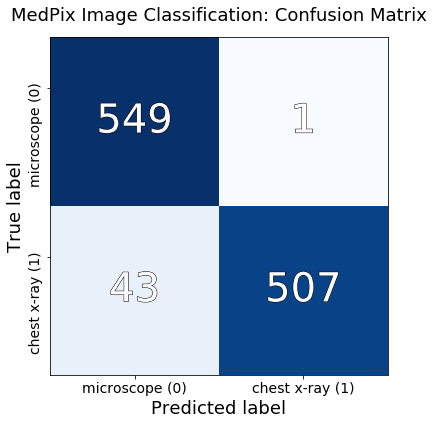

In [20]:
plot_confusion_matrix(
    confmat,
    title = 'MedPix Image Classification: Confusion Matrix',
    labels = ['microscope (0)', 'chest x-ray (1)'])

In [21]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.93      1.00      0.96       550
          1       1.00      0.92      0.96       550

avg / total       0.96      0.96      0.96      1100



## Singleton testing

In [22]:
def lets_guess(true_class = 'micro'):
    rand = random.randint(0, 6)
    path = 'other_assets/validation_set/{}/{}_{}.png'.format(true_class, true_class, rand)
    display(Image_(path))
    test_image = image.load_img(path, target_size = (64, 64))
    test_image = image.img_to_array(test_image)
    test_image = np.expand_dims(test_image, axis = 0)
    result = classifier.predict(test_image)
    print('Model says...')
    if true_class == 'micro':        
        if result[0][0] == 1:
            print('Sorry, it\'s a chest X-ray.') ## false positive
        else:
            print('Good guess!  It\'s a microscope photo!') ## true negative
    elif true_class == 'chest':
        if result[0][0] == 1:
            print('Good guess!  It\'s a chest X-ray!') ## true positive
        else:
            print('Sorry, it\'s a microscope photo :(') ## false negative
    return

#### Drumroll...

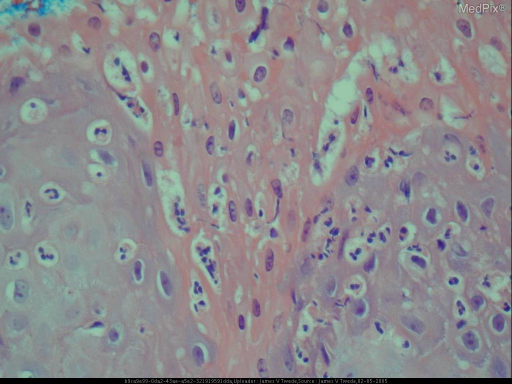

Model says...
Good guess!  It's a microscope photo!


In [23]:
lets_guess()

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Cleaner data set, hyperparameter tuning, etc. can be done to improve results moving forward.  (Good tuning site [here](https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/).)

_*_Under construction_*_

In [16]:
import numpy.ma as ma
def make_mosaic(imgs, nrows, ncols, border=1):
    """
    Given a set of images with all the same shape, makes a
    mosaic with nrows and ncols
    """
    nimgs = imgs.shape[0]
    imshape = imgs.shape[1:]
    
    mosaic = ma.masked_all((nrows * imshape[0] + (nrows - 1) * border,
                            ncols * imshape[1] + (ncols - 1) * border),
                            dtype=np.float32)
    
    paddedh = imshape[0] + border
    paddedw = imshape[1] + border
    for i in xrange(nimgs):
        row = int(np.floor(i / ncols))
        col = i % ncols
        
        mosaic[row * paddedh:row * paddedh + imshape[0],
               col * paddedw:col * paddedw + imshape[1]] = imgs[i]
    return mosaic

In [17]:
# Visualize weights
W = classifier.layers[0].W.get_value(borrow=True)
W = np.squeeze(W)
print("W shape : ", W.shape)

pl.figure(figsize=(15, 15))
pl.title('conv1 weights')
nice_imshow(pl.gca(), make_mosaic(W, 6, 6), cmap=cm.binary)

AttributeError: 'Conv2D' object has no attribute 'W'

In [ ]:
# Visualize convolution result (after activation)
C1 = convout1_f(X)
C1 = np.squeeze(C1)
print("C1 shape : ", C1.shape)

pl.figure(figsize=(15, 15))
pl.suptitle('convout1')
nice_imshow(pl.gca(), make_mosaic(C1, 6, 6), cmap=cm.binary)